In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import h5py
import scipy.interpolate as sci
from scipy import interpolate
import astropy.time as time
import astropy.coordinates as coords
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interp1d
from tqdm import tnrange, tqdm_notebook
import numpy as np
from PyAstronomy import pyasl
import os

In [2]:
def vac2air(wv_vac):
    s = 10.**4 /wv_vac
    n = 1.+0.0000834254+0.02406147/(130.-s**2)+0.00015998/(38.9-s**2)
    wv_air=wv_vac/n
    return wv_air



def logL_broli(fa,fia,n):
    fb=np.transpose(fa)
    fib=np.transpose(fia[:n])
    nf=np.sum((fb-np.mean(fb,axis=0))**2,axis=0)/n
    nfi=np.sum((fib-np.mean(fib,axis=0))**2,axis=0)/n
    
    R=np.dot(np.transpose(nf),nfi)
    logL= -1.*n/2.*np.log(nf-2.*R+nfi)

    return logL

ra=np.array([57, 56, 55, 52, 51, 50, 49, 48, 47, 46, 41, 40, 39]) #specific CARMENES orders containing water features

# SYSREM

In [3]:
import numpy as np
import h5py
from  tqdm import tqdm
from tqdm import tnrange, tqdm_notebook
from scipy.stats import sigmaclip as sigmaclip
def sysrem_iter(order_spec,error,airmass,iteran):
    # SYSREM Iteration sequence to find the 'optimized airmass' and 'optimized color'
    a_fake=[] # 'airmass'
    c_fake=[] # 'color'
    a_fake_std=[]
    c_fake_std=[]
    sysrem_iter=[]

    a_fake.append(airmass)
    a0=1e-6
    c0=1e-6

    for iter in range (iteran):
        c_i=[] # iterated color
        a_j=[] # iterated airmass
        

        c_up=np.dot((order_spec/np.square(error)).transpose(),a_fake[-1])
        c_down=np.dot(1./np.square(error).transpose(),np.square(a_fake[-1]))
        c_fake.append(c_up/c_down)
        

        a_up=np.dot((order_spec/np.square(error)),c_fake[-1])
        a_down=np.dot(1./np.square(error),np.square(c_fake[-1]))
        a_fake.append(a_up/a_down)

        a_fake_std.append(np.nansum(np.abs(a_fake[-1]-a0))/np.nansum(np.abs(a0)))
        c_fake_std.append(np.nansum(np.abs(c_fake[-1]-c0))/np.nansum(np.abs(c0)))
        
        a0=a_fake[-1]
        c0=c_fake[-1]
        
        if iter >10:
            if a_fake_std[-1] <1e-5 and c_fake_std[-1] <1e-5:
                break        

    sysrem_iter=np.outer(a_fake[-1],c_fake[-1])
    return sysrem_iter, a_fake, c_fake,a_fake_std,c_fake_std

def sysrem_full_mag(spec,error,n_sys,airmass,iteran):
    # SYSREM
    error_sys=[]
    error_sys.append(error)
    error=(2.5/spec/np.log(10)*error)
    data= -2.5*np.log10(spec)
    
    data=data-np.mean(data,axis=0)[np.newaxis,:]
    reduced_collect=[]
    sysrem_collect=[]
    
    a_sys=[]
    c_sys=[]
    a_std_sys=[]
    c_std_sys=[]
    reddata=10**(np.copy(data)/-2.5)
    reddata=reddata
    reduced_collect.append(reddata)
    

    for systematics in tnrange(n_sys,ascii="True",desc="Systematics:"):
        sysrem_systematics,a_fake,c_fake,a_fake_std,c_fake_std=sysrem_iter(data,error,airmass,iteran) # calculating the systematics using SYSREM
        data=data-sysrem_systematics # Subtracting systematics from the data
        reddata=10**(np.copy(data)/-2.5)
        reddata=reddata
        reduced_collect.append(reddata)
        sysrem_collect.append(sysrem_systematics)
        
        error_sys.append(error_sys[systematics]/10**((sysrem_systematics+np.mean(-2.5*np.log10(spec),axis=0)[np.newaxis,:])/-2.5))
        a_sys.append(a_fake)
        c_sys.append(c_fake)
        a_std_sys.append(a_fake_std)
        c_std_sys.append(c_fake_std)
        
    reduced_collect=np.array(reduced_collect,dtype="float")
    sysrem_collect=np.array(sysrem_collect,dtype="float")
    
    return reduced_collect,sysrem_collect, a_sys, c_sys,a_std_sys,c_std_sys,error_sys

def sysrem_full_flux(spec,error,n_sys,airmass,iteran):
    # SYSREM
    data=spec-np.mean(spec,axis=0)[np.newaxis,:]
    
    error=error

    reduced_collect=[]
    sysrem_collect=[]
    error_sys=[]
    a_sys=[]
    c_sys=[]
    a_std_sys=[]
    c_std_sys=[]
    model_sys=[]
    sysrem_collect.append(np.mean(spec,axis=0)[np.newaxis,:]*np.ones(np.shape(spec)))
    
    for systematics in tnrange(n_sys,ascii="True",desc="Systematics:"):
        sysrem_systematics,a_fake,c_fake,a_fake_std,c_fake_std=sysrem_iter(data,error,airmass,iteran)
        data=data-sysrem_systematics
        sysrem_collect.append(sysrem_systematics)        
        a_sys.append(a_fake)
        c_sys.append(c_fake)
        a_std_sys.append(a_fake_std)
        c_std_sys.append(c_fake_std)

    for systematics in range(n_sys+1):
        model= np.sum(sysrem_collect[:systematics+1],axis=0)
        residual= spec/model
        model_sys.append(model)
        reduced_collect.append(residual)
        error_sys.append(error/model)

    reduced_collect=np.array(reduced_collect,dtype="float")
    model_sys=np.array(model_sys,dtype="float")
    return reduced_collect,model_sys, a_sys, c_sys,a_std_sys,c_std_sys,error_sys

def sysrem_full_flux_sub(spec,error,n_sys,airmass,iteran):
    # SYSREM
    data=spec-np.mean(spec,axis=0)[np.newaxis,:]
    
    error=error

    reduced_collect=[]
    sysrem_collect=[]
    error_sys=[]
    a_sys=[]
    c_sys=[]
    a_std_sys=[]
    c_std_sys=[]
    model_sys=[]
    sysrem_collect.append(np.mean(spec,axis=0)[np.newaxis,:]*np.ones(np.shape(spec)))
    
    for systematics in tnrange(n_sys,ascii="True",desc="Systematics:"):
        sysrem_systematics,a_fake,c_fake,a_fake_std,c_fake_std=sysrem_iter(data,error,airmass,iteran)
        data=data-sysrem_systematics
        sysrem_collect.append(sysrem_systematics)        
        a_sys.append(a_fake)
        c_sys.append(c_fake)
        a_std_sys.append(a_fake_std)
        c_std_sys.append(c_fake_std)

    for systematics in range(n_sys+1):
        model= np.sum(sysrem_collect[:systematics+1],axis=0)
        residual= spec-model
        model_sys.append(model)
        reduced_collect.append(residual)
        error_sys.append(error)

    reduced_collect=np.array(reduced_collect,dtype="float")
    model_sys=np.array(model_sys,dtype="float")
    return reduced_collect,model_sys, a_sys, c_sys,a_std_sys,c_std_sys,error_sys

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


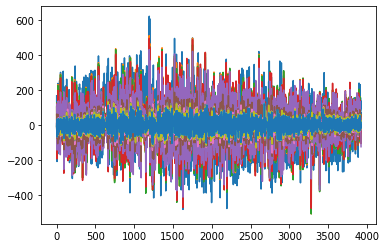

<Figure size 432x288 with 0 Axes>

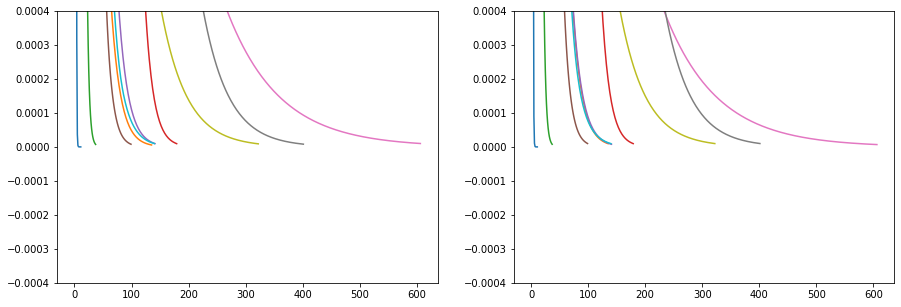

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

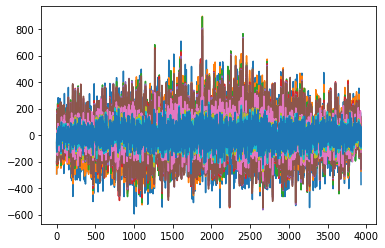

<Figure size 432x288 with 0 Axes>

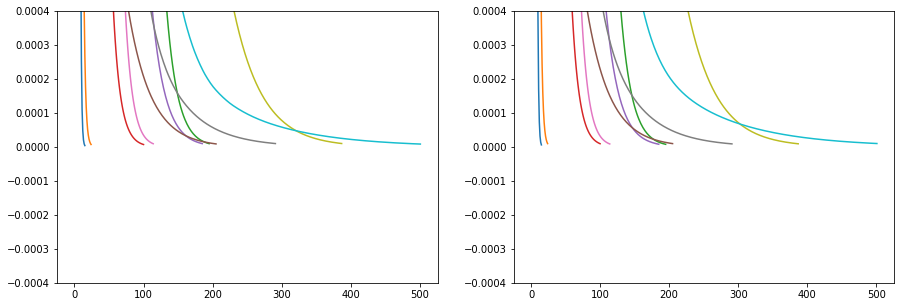

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

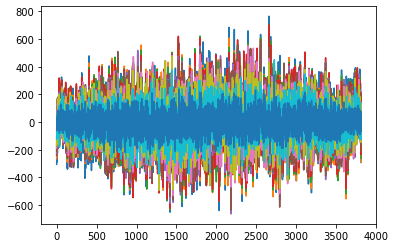

<Figure size 432x288 with 0 Axes>

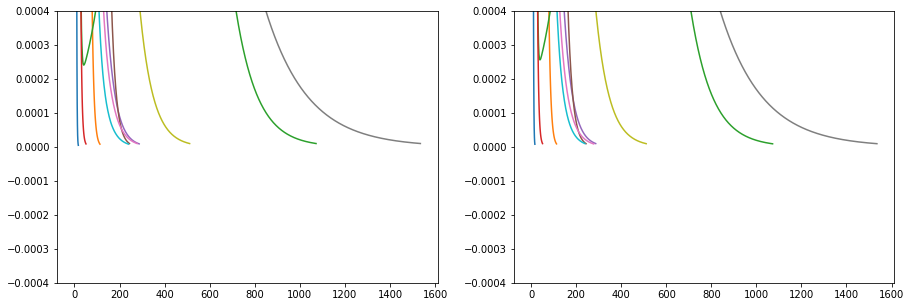

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

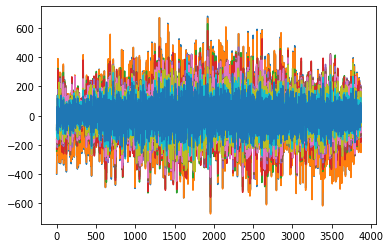

<Figure size 432x288 with 0 Axes>

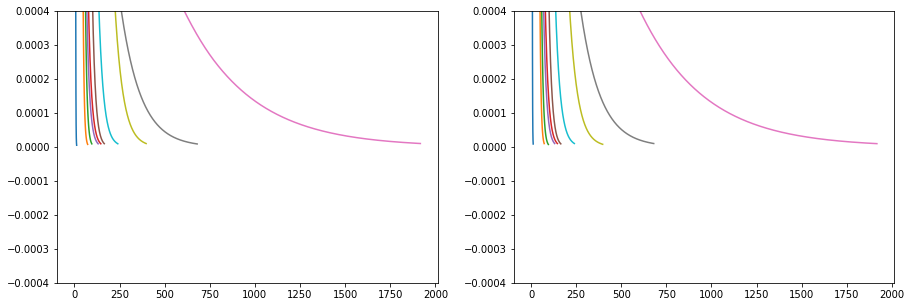

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

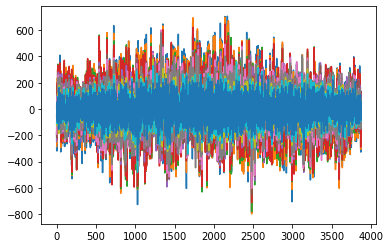

<Figure size 432x288 with 0 Axes>

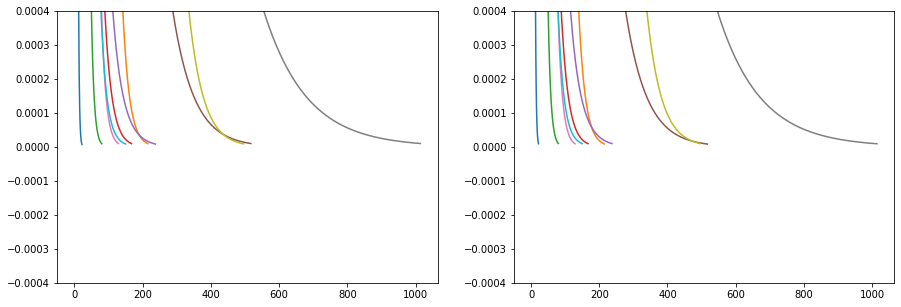

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

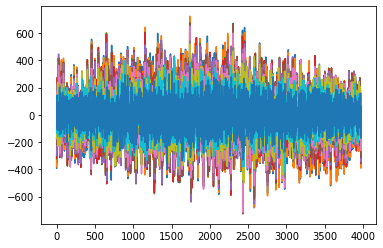

<Figure size 432x288 with 0 Axes>

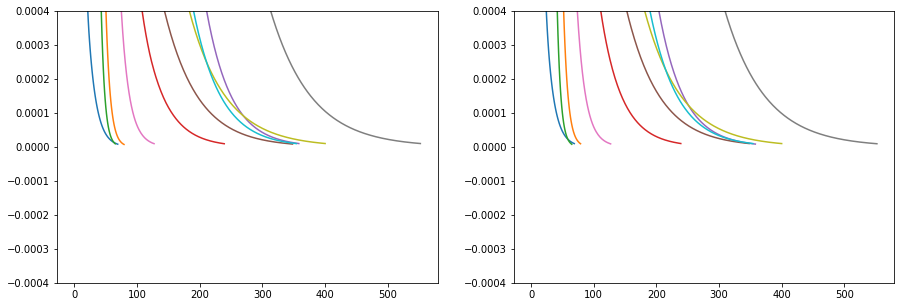

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

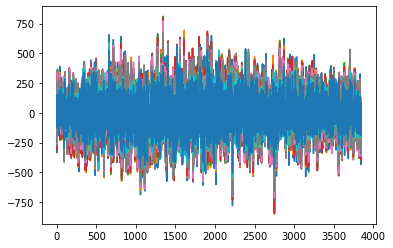

<Figure size 432x288 with 0 Axes>

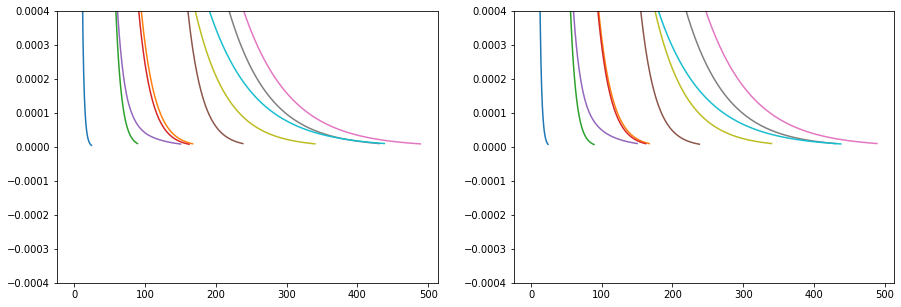

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

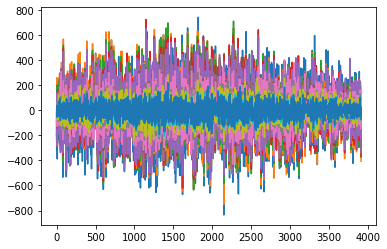

<Figure size 432x288 with 0 Axes>

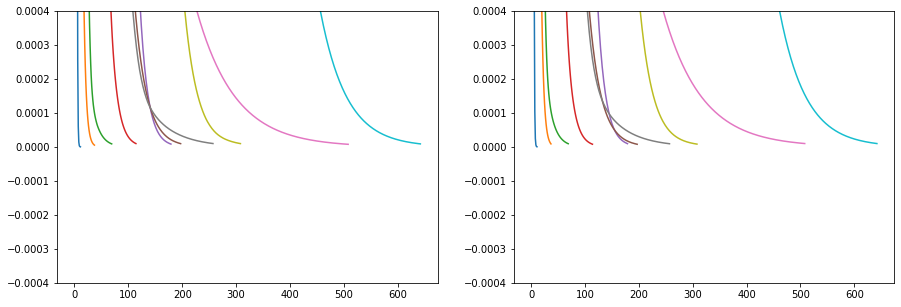

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

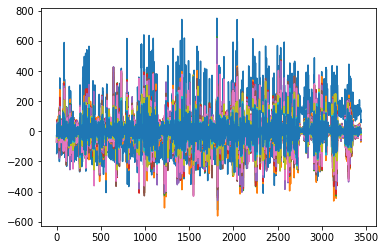

<Figure size 432x288 with 0 Axes>

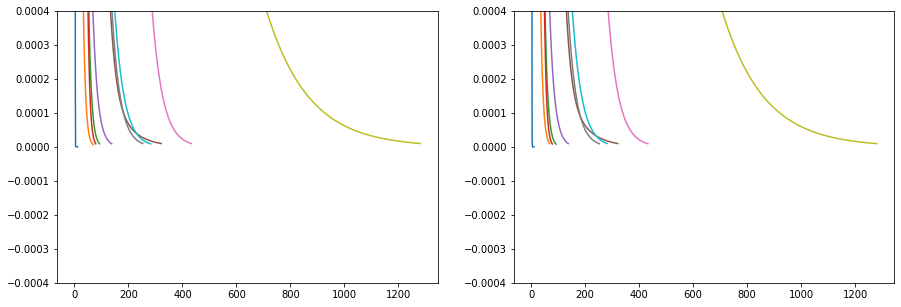

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

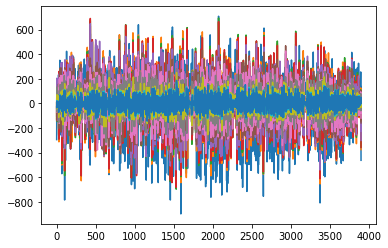

<Figure size 432x288 with 0 Axes>

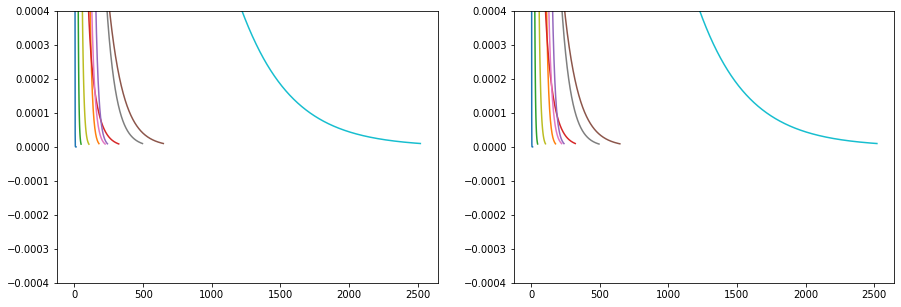

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

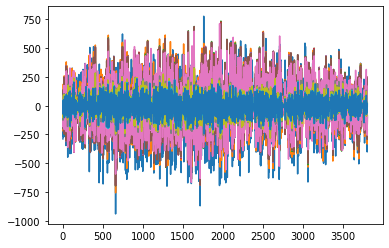

<Figure size 432x288 with 0 Axes>

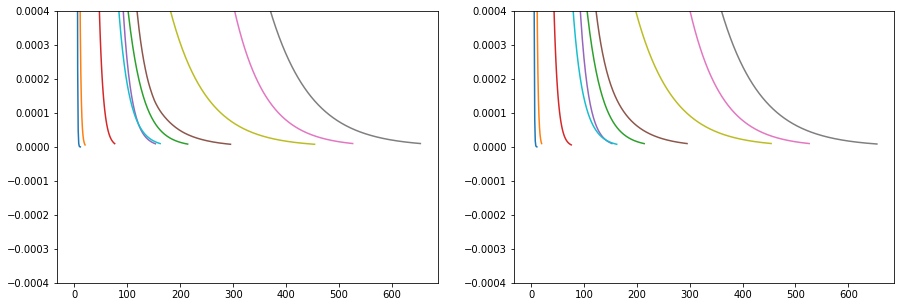

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

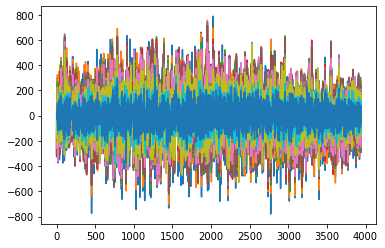

<Figure size 432x288 with 0 Axes>

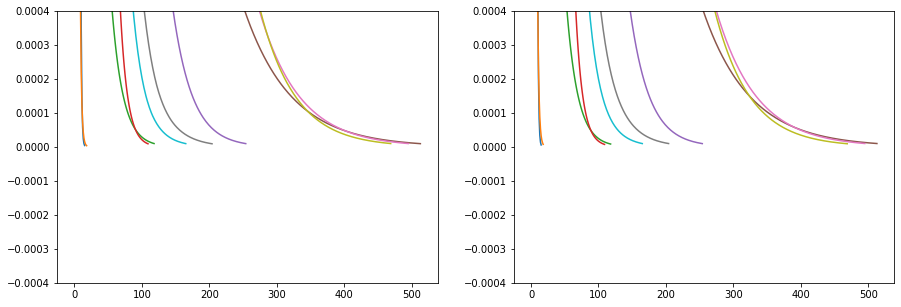

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

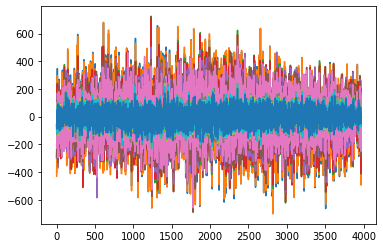

<Figure size 432x288 with 0 Axes>

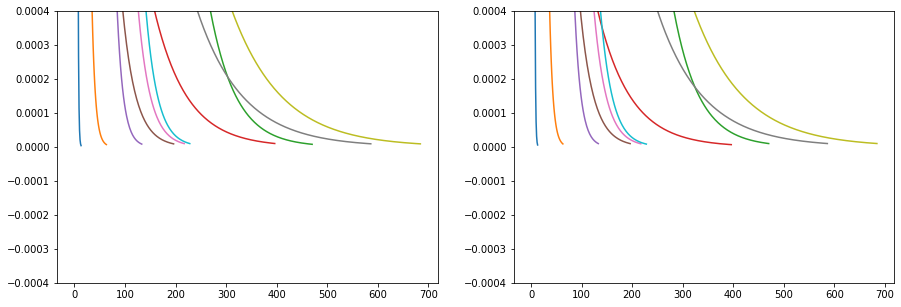

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

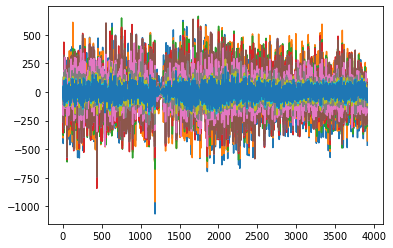

<Figure size 432x288 with 0 Axes>

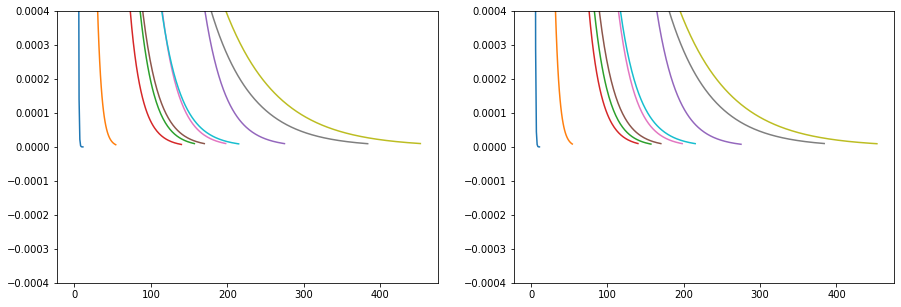

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

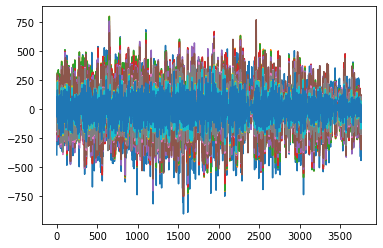

<Figure size 432x288 with 0 Axes>

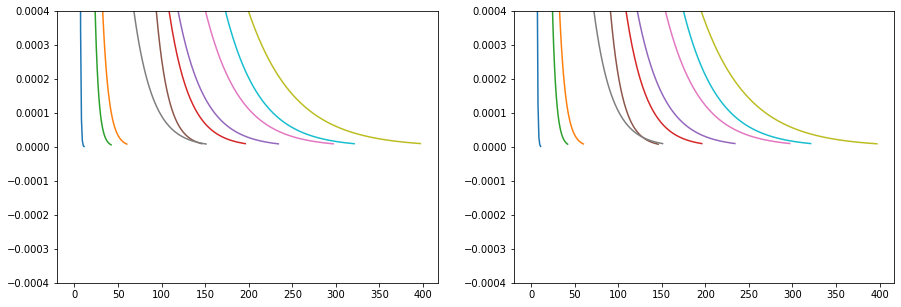

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

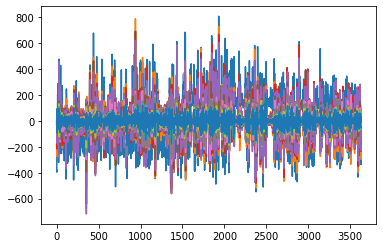

<Figure size 432x288 with 0 Axes>

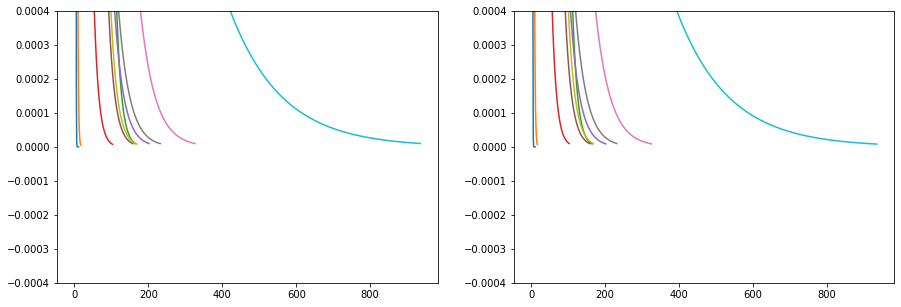

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

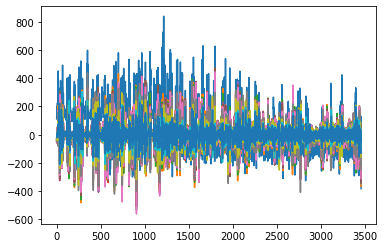

<Figure size 432x288 with 0 Axes>

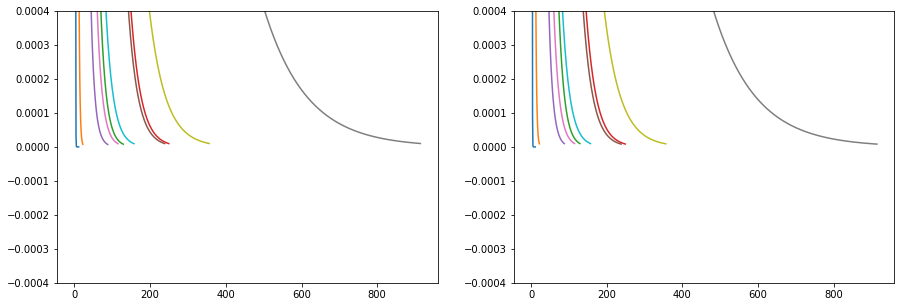

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

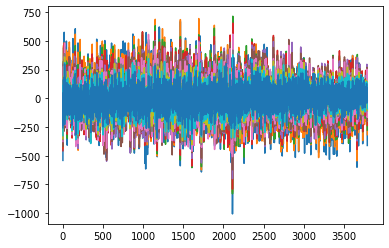

<Figure size 432x288 with 0 Axes>

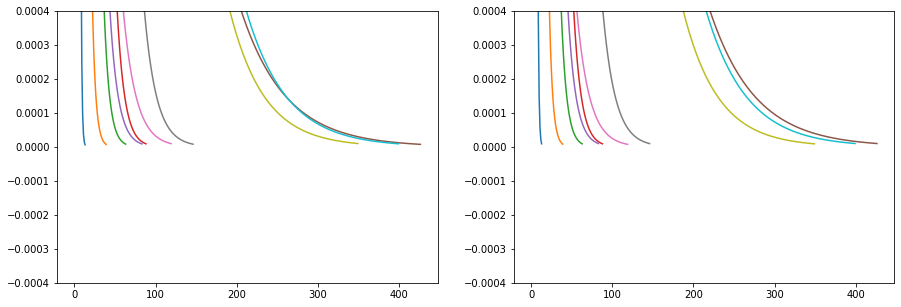

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

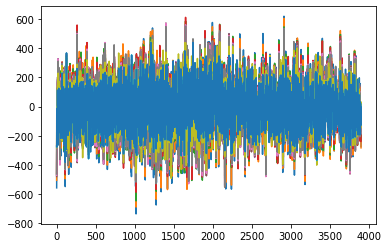

<Figure size 432x288 with 0 Axes>

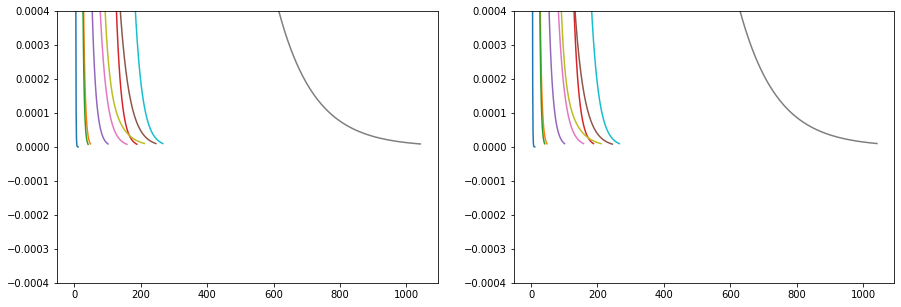

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

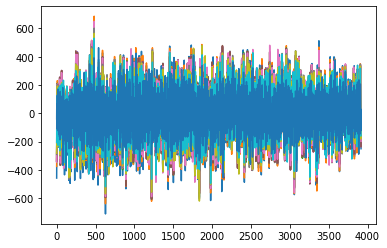

<Figure size 432x288 with 0 Axes>

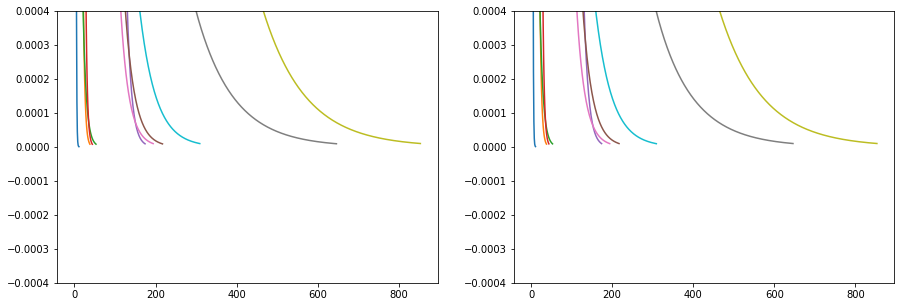

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

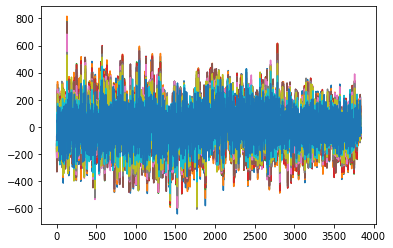

<Figure size 432x288 with 0 Axes>

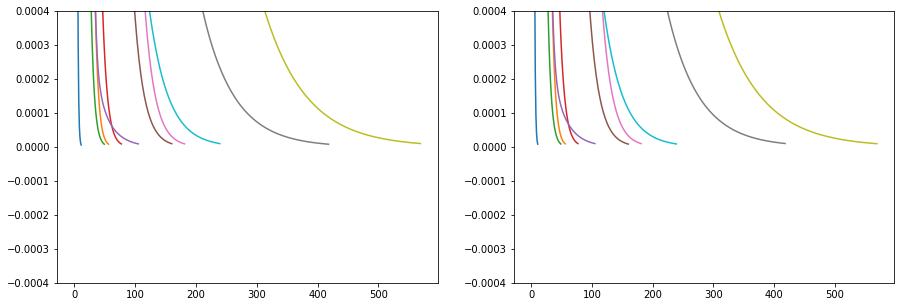

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<Figure size 432x288 with 0 Axes>

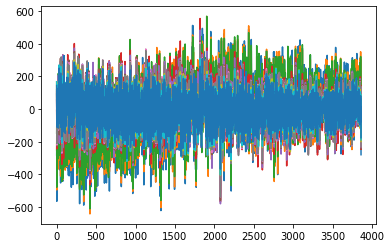

<Figure size 432x288 with 0 Axes>

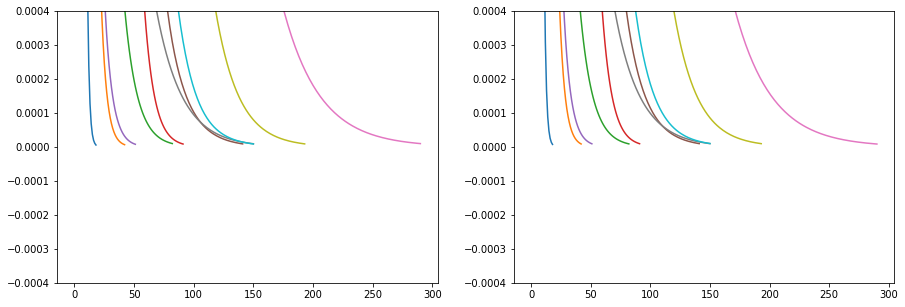




Output file: hd189733-carmenes-nir-raw-true.postsys_sub
Thank you. Now you can proceed to the cross correlation step or inspecting the SYSREM result


<Figure size 432x288 with 0 Axes>

In [98]:
n_sys=10 # number of systematics to be extracted by SYSREM e.g = 15 (default)
iteran=20000 # number of iteration for calculating optimized airmass and color e.g 1000 (default)

input_file= "hd189733-carmenes-nir-raw-true.h5"

output_file= input_file[:-2]+"postsys_sub" # filename of the output

h5f_raw = h5py.File(str(input_file)+"", 'r')

airmass=h5f_raw["airmass"][:] #airmass
ordernum=h5f_raw["order number"][:] #the real numbering of the spectral order
with h5py.File(str(output_file), 'w') as h5f_sysrem:# Make the output h5py file

    for order in tnrange (len(ordernum),ascii="True",desc= " Order:"): #len ordernum is the number of the spectral order
        flux = h5f_raw["red-flux-order-"+str(ordernum[order])][:] # Load the spectrum matrix of specific order
        Se= np.sqrt(h5f_raw["red-variance-order-"+str(ordernum[order])][:]) #Load the variance per pixels of specific order

        error=(np.outer(np.std(flux,axis=1),np.std(flux,axis=0))/np.std(flux))

        sys_flux_order,sys_sys_order,a_sys,c_sys,a_std_sys,c_std_sys,error_sys=sysrem_full_flux_sub(flux,error,n_sys,airmass,iteran)
#         sys_flux_order,sys_sys_order,a_sys,c_sys,a_std_sys,c_std_sys,error_sys=sysrem_full_flux(flux,error,n_sys,airmass,iteran)
#         sys_flux_order,sys_sys_order,a_sys,c_sys,a_std_sys,c_std_sys,error_sys=sysrem_full_mag(flux,error,n_sys,airmass,iteran)

        order_spec_sys=[]
        error_spec_sys=[]
        for sys in range(len(sys_flux_order)):
            order_spec=sys_flux_order[sys]
            totalerr=error_sys[sys]
            for wvbin in range(len(order_spec[0])):
                fl=order_spec[:,wvbin]
                c, low, upp =sigmaclip(fl, low=5,high=5)
                order_spec[:,wvbin][np.abs(fl-np.mean(c))>+5*np.std(c)]= np.mean(c)

            order_spec_sys.append(order_spec-np.median(order_spec,axis=1)[:,np.newaxis])
            error_spec_sys.append(totalerr)

        plt.figure()
        for i in range(len(sys_flux_order)):
            plt.plot((order_spec_sys/np.square(totalerr))[i][0])
        plt.show()
        plt.clf()

        plt.figure(figsize=(15,5))
        ax1=plt.subplot(121)
        ax2=plt.subplot(122)
        for sys in range(len(a_std_sys)):
            ax1.plot(a_std_sys[sys])
        ax1.set_ylim(-0.0004,0.0004)
        for sys in range(len(a_std_sys)):
            ax2.plot(c_std_sys[sys])
        ax2.set_ylim(-0.0004,0.0004)
        plt.show()
        plt.clf()

        h5f_sysrem.create_dataset("flux-order-"+str(ordernum[order])+"sysrem",
                                  data=order_spec_sys,dtype='f', compression="gzip")
        h5f_sysrem.create_dataset("error-order-"+str(ordernum[order])+"sysrem",
                                  data=error_spec_sys,dtype='f', compression="gzip")

h5f_raw.close()
print ("\n")
print ("Output file: "+str(output_file))
print ("Thank you. Now you can proceed to the cross correlation step or inspecting the SYSREM result")

# Cross-correlation

## Definition

In [56]:
def crossvar(fa,fia):
    fib = np.transpose(fia)
    cc  = np.dot(fa,fib)
    return cc

def cc_chi_packA1(yobs,var,y_temp_order):
    K1= (yobs**2/var).sum(axis=1)
    K2= np.dot(y_temp_order**2,1./var.transpose()).transpose()
    CC= crossvar(yobs/var,y_temp_order)
    return K1,K2,CC

def crosscoall(fa,fia):
    
    fb=np.transpose(fa)
    fib=np.transpose(fia)
    nf=(fb-np.mean(fb,axis=0))
    nfi=(fib-np.mean(fib,axis=0))
    up=np.dot(np.transpose(nf),nfi)
    bottom=np.outer(np.sum(nf**2,axis=0),np.sum(nfi**2,axis=0))
    cc = up/(np.sqrt(bottom))
    return cc


## Transit Modelling

In [5]:
input_file= "hd189733-carmenes-nir-raw-true.h5"
h5f_raw = h5py.File(str(input_file)+"", 'r')
rvcor=h5f_raw["rvcor"][:]
phase=h5f_raw["phase"][:]
bjd=h5f_raw["bjd"][:]

phase_p=[]
for i in range(len(phase)):
    if phase[i]> 0.5:
        phase_p.append(phase[i]-1.)
    else:
        phase_p.append(phase[i])

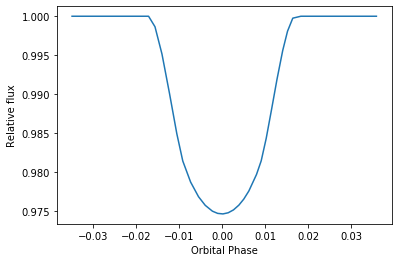

In [6]:
import batman
import numpy as np
import matplotlib.pyplot as plt

P=2.21857567 #days
T0=2454279.436714

params = batman.TransitParams()
params.t0 = T0                       #time of inferior conjunction
params.per = P                      #orbital period
params.rp = 0.15463                  #planet radius (in units of stellar radii)
params.a = 8.81                  #semi-major axis (in units of stellar radii)
params.inc = 85.58                   #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [1.082, -0.2315]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

t = np.array(bjd)+2400000.

m = batman.TransitModel(params, t)    #initializes model
t_model = m.light_curve(params)          #calculates light curve
plt.plot(phase_p, t_model)
plt.xlabel("Orbital Phase")
plt.ylabel("Relative flux")
plt.show()


scaletrans=np.abs(t_model-1)/np.max(np.abs(t_model-1))
for i in range(len(t_model)):
    if scaletrans[i]>0:
            scaletrans[i]=1
            
            

In [7]:
tw=(1.-t_model)/np.max((1.-t_model))

## Spectrum Template

In [8]:
#Setting up parameters
kpmin=-260
kpmax=260
vsysmin=-400
vsysmax=400

v_step=1.

rvcor=np.array(rvcor)
phase_p=np.array(phase_p)
kp= np.arange(kpmin,kpmax+v_step,v_step)
vsys= np.arange(vsysmin,vsysmax+v_step,v_step)

v1=kpmax*np.sin(2.*np.pi*phase_p)+(vsysmax)-np.array(rvcor) #Positive means red shifted, predicted observed RV
v2=kpmin*np.sin(2.*np.pi*phase_p)+(vsysmax)-np.array(rvcor)
v3=kpmax*np.sin(2.*np.pi*phase_p)+(vsysmin)-np.array(rvcor)
v4=kpmin*np.sin(2.*np.pi*phase_p)+(vsysmin)-np.array(rvcor)

drvs= np.arange(np.min([v1,v2,v3,v4])-50., np.max([v1,v2,v3,v4])+50.+v_step, v_step)
print (len(drvs))

1018


In [30]:
#Doppler shifting the template
w_model,s_model=np.loadtxt("./hd189_brogi_h2o-5-1e-60-trans-vacuum.spec",unpack=True)

#Maximum filter to remove the upper envelope
binsize=800
binned=[]
x=[]
for i in range(0,s_model.shape[0]-binsize,binsize):
   x.append(i+binsize/2.)
   binned.append(np.max(s_model[i:i+binsize]))
conti_=sci.interp1d(np.asarray(x),np.asarray(binned),
                     kind='linear',bounds_error=False,fill_value='extrapolate')(np.arange(s_model.shape[0]))

s_norm=s_model-conti_   
h5f_raw= h5py.File("./hd189733-carmenes-nir-raw-true.h5", 'r')
ordernum=h5f_raw["order number"][:]

with h5py.File("./hd189733-carmenes-nir-H2O-true.temp", 'w') as h5f_temp:
    for order in tqdm(range(len(ordernum))):
        w=h5f_raw["red-wv-order-"+str(ordernum[order])][:]
        masked=(w_model>w[0]-50)*(w_model<w[-1]+50)
        xtemp,ytempnorm=w_model[masked],s_norm[masked]
        template_exo = np.zeros(shape=(len(drvs),len(w)),dtype="float")
        for i in range(len(drvs)):
            fi = sci.interp1d(xtemp*(1.0 + (drvs[i])*1000./const.c.value), ytempnorm)
            template_exo[i,:]= fi(w)

        h5f_temp.create_dataset("order-"+str(ordernum[order])+'H2O',
                                data=template_exo,dtype='f', compression="gzip")
h5f_raw.close()

100%|██████████| 22/22 [00:19<00:00,  1.14it/s]


In [93]:
ls

'CARMENES-HD18733b-Transmission Spectroscopy-Example-logL.ipynb'
'CARMENES-HD18733b-Transmission Spectroscopy-Example.ipynb'
 README
 README~
 h2o1e-60-pearson.cc
 hd189733-carmenes-nir-H2O-true.temp
 hd189733-carmenes-nir-raw-true.h5
 hd189733-carmenes-nir-raw-true.postsys_flux
 hd189733-carmenes-nir-raw-true.postsys_mag
 hd189733-carmenes-nir-raw-true.postsys_sub
 hd189_brogi_h2o-5-1e-60-trans-vacuum.spec
 tamuz+2004.pdf


In [99]:
rm  h2o1e-60-pearson.cc

## Cross-correlating the SYSREM residual with the Doppler-shifted spectrum template 

In [101]:
# Using new sysrem_np script
len_sys=11
inputpostsys="./hd189733-carmenes-nir-raw-true.postsys_mag"

h5f_raw=h5py.File("hd189733-carmenes-nir-raw-true.h5", 'r')
h5f_reduced=h5py.File(inputpostsys, 'r')
h5f_temp=h5py.File("./hd189733-carmenes-nir-H2O-true.temp", 'r')
ordernum=h5f_raw["order number"][:]
h5f_cc.close()
with h5py.File("./h2o1e-60-pearson-mag.cc", 'w') as h5f_cc:
    for order in tnrange(len(ordernum),ascii="True",desc=" Order"):
        y_temp_order=h5f_temp["order-"+str(ordernum[order])+'H2O'][:]
        yobs=h5f_reduced["flux-order-"+str(ordernum[order])+"sysrem"][:]
        error=h5f_reduced["error-order-"+str(ordernum[order])+"sysrem"][:]

        
        K1_collect=[]
        K2_collect=[]
        CC_collect=[]

        for systematics in tnrange(len_sys,ascii="True",desc="Nsys"):

            order_spec=yobs[systematics]
            var=np.square(error[systematics])

            # Performing high-pass filter to remove low order variation
            for filenum in range (len(order_spec)):
                sm = pyasl.smooth(order_spec[filenum], 325, 'flat')
                sm1 = pyasl.smooth(sm, 551, 'flat')
                order_spec[filenum]=order_spec[filenum]-sm1

            # Cross-correlating reduced data with the model spectrum
#             K1,K2,cc=cc_chi_packA1(order_spec,var,y_temp_order)
            cc=crosscoall(order_spec,y_temp_order)
    
            CC_collect.append(cc)
            K1_collect.append(K1)
            K2_collect.append(K2)
            

        h5f_cc.create_dataset("CC-H2O-order-"+str(ordernum[order]),
                              data=CC_collect,dtype='f', compression="gzip")
#         h5f_cc.create_dataset("K1-H2O-order-"+str(ordernum[order]),
#                               data=K1_collect,dtype='f', compression="gzip")
#         h5f_cc.create_dataset("K2-H2O-order-"+str(ordernum[order]),
#                               data=K2_collect,dtype='f', compression="gzip")                                            
    h5f_reduced.close()
    h5f_temp.close()

/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # This is added back by InteractiveShellApp.init_path()


/home/stev/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


# Result

In [102]:
left, width = 0.1, 0.4
bottom, height = 0.1, 0.4
bottom_h = left_h = left + width + 0.02

rect_scatter = [left+0.1, bottom, width, height]
rect_histx = [left+0.1, bottom_h, width, 0.15]
rect_histy = [left_h+0.1, bottom, 0.10, height]

def kp_fig(kp_vsysmap_all,vsys,kp):
    plt.figure(figsize=(15,10))
    kp_indmax,vsys_indmax = np.unravel_index(np.abs(kp_vsysmap_all).argmax(),kp_vsysmap_all.shape)

    maskedpeak=np.abs(kp_vsysmap_all)>-1
    maskedpeak[kp_indmax-30:kp_indmax+30,vsys_indmax-30:vsys_indmax+30]=1<0
    
    snmap=kp_vsysmap_all/np.std(kp_vsysmap_all[maskedpeak])
    
    axScatter = plt.axes(rect_scatter)
    mapSN=axScatter.pcolormesh(vsys,kp,snmap,cmap=cm.inferno)
    axScatter.set_xlabel("V$_{sys}$ (km/s)")
    axScatter.set_ylabel("K$_{p}$ (km/s)")
    axScatter.axvline(x=vsys[vsys_indmax],color="white",ls="--",alpha= 0.4)
    axScatter.axhline(y=kp[kp_indmax],color="white",ls="--",alpha= 0.4)
        
    axVsyscurve=plt.axes(rect_histx)
    axVsyscurve.plot(vsys,snmap[kp_indmax,:])
    axVsyscurve.set_xlim(vsys[0],vsys[-1])
    axVsyscurve.set_xticklabels("")
    axVsyscurve.set_ylabel("S/N ($\sigma$)")
    
    axKpcurve = plt.axes(rect_histy)
    axKpcurve.plot(snmap[:,vsys_indmax],kp)
    axKpcurve.set_ylim(kp[0],kp[-1])
    axKpcurve.set_yticklabels("")
    axKpcurve.set_xlabel("S/N ($\sigma$)")
    print (str(sys)+' SYSREM')
    print ('S/N = '+str(snmap[kp_indmax,vsys_indmax]))
    print ('Kp  = '+str(kp[kp_indmax])+' km/s')
    print ('Vsys= '+str(vsys[vsys_indmax])+' km/s')
    plt.colorbar(mapSN,label="S/N ($\sigma$)",format="%.1f")
    plt.show()
    
    return vsys[vsys_indmax], kp[kp_indmax]


def kpvsys_calc(kp,vsys,drvs,data,orb_phase,brv,mask):
    data=data[mask]
    orb_phase=orb_phase[mask]
    brv=brv[mask]
    
    Dresamp= np.zeros((len(kp),len(orb_phase),len(vsys)))
    for i,kp_i in enumerate(kp):
        v_predicted=kp_i*np.sin(2.*np.pi*orb_phase)+brv
        for orb in range(orb_phase.size):
          Dresamp[i,orb] = sci.interp1d(drvs,data[orb],kind="linear")(v_predicted[orb]+vsys)
    summed=Dresamp.sum(axis=1)
    return summed


## Using log Likelihood

$\mathrm{CCF}= \sum \frac{f_{i}m_{i}}{\sigma_{i}^{2}}$

where $f_{i}$ is the mean-subtracted data, $m_{i}$ is the mean-subtracted spectrum model, $\sigma_{i}$ is the error at $i$ wavelength bin

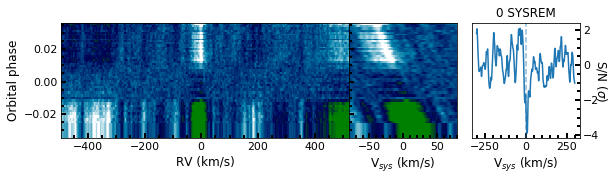

0 SYSREM
S/N = 5.416967730580357
Kp  = -157 km/s
Vsys= 1 km/s


<Figure size 432x288 with 0 Axes>

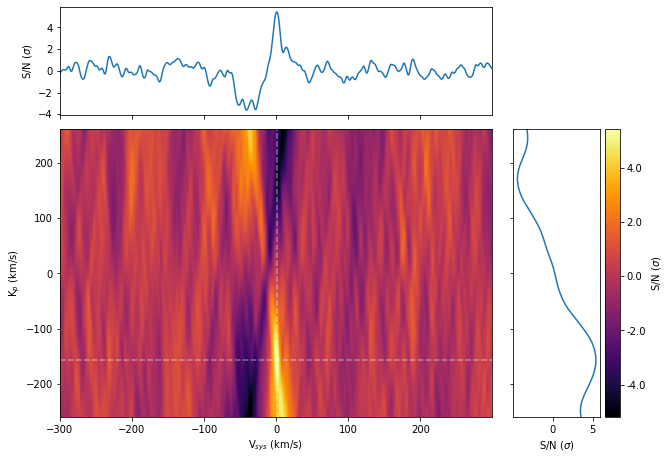

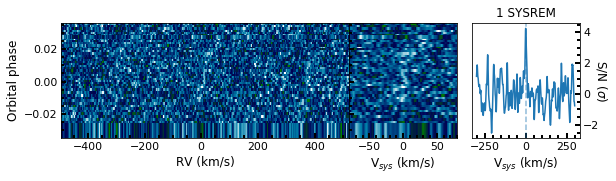

1 SYSREM
S/N = 4.98335503188486
Kp  = 152 km/s
Vsys= -6 km/s


<Figure size 432x288 with 0 Axes>

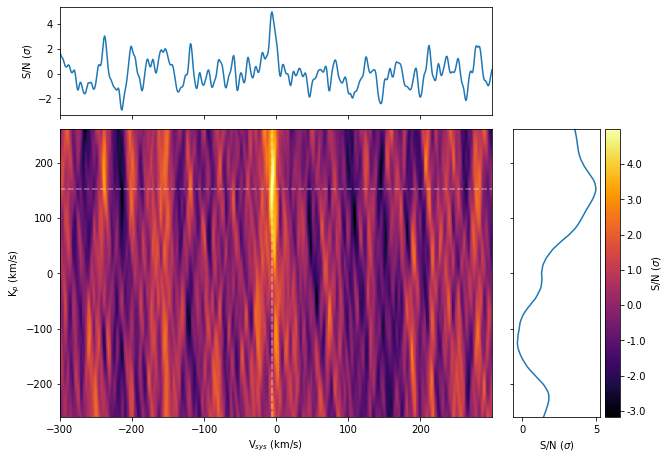

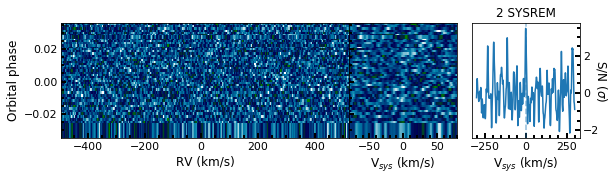

2 SYSREM
S/N = 3.8683091130018084
Kp  = 153 km/s
Vsys= -6 km/s


<Figure size 432x288 with 0 Axes>

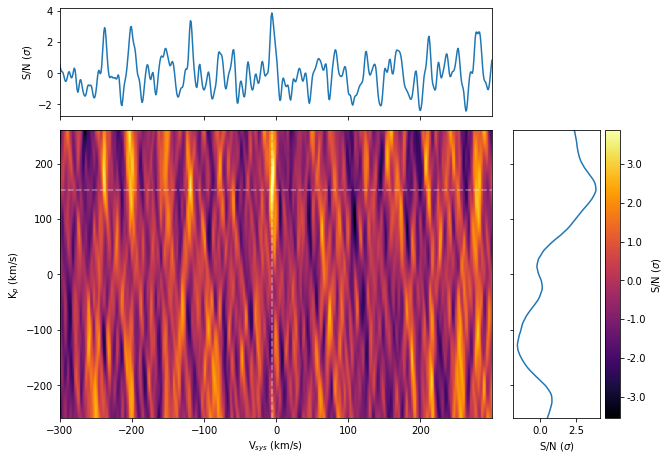

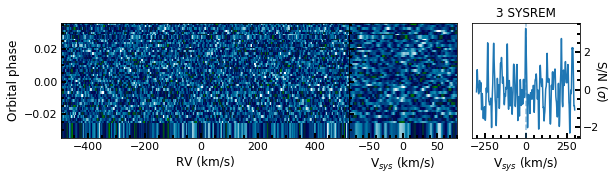

3 SYSREM
S/N = 3.9705172243587765
Kp  = 195 km/s
Vsys= 208 km/s


<Figure size 432x288 with 0 Axes>

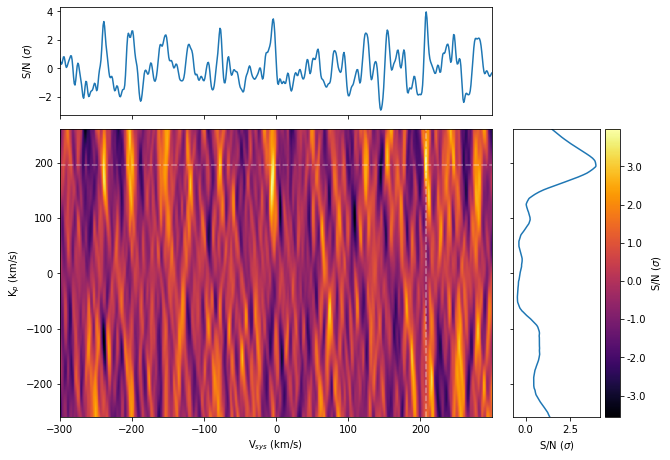

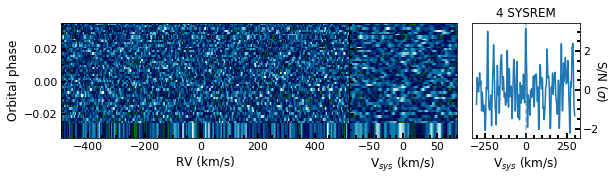

4 SYSREM
S/N = 3.9920919689416294
Kp  = 177 km/s
Vsys= -239 km/s


<Figure size 432x288 with 0 Axes>

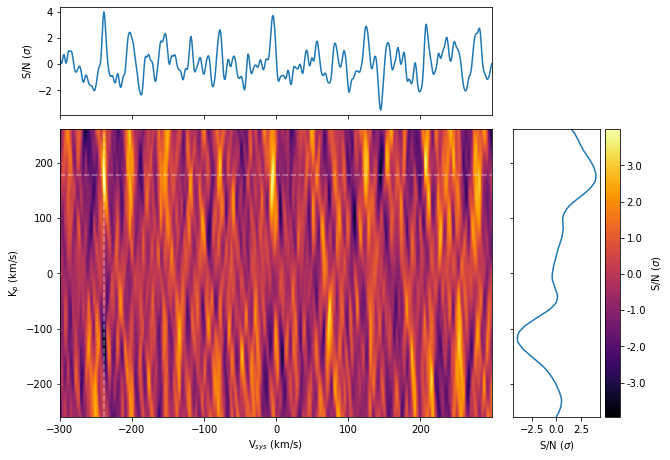

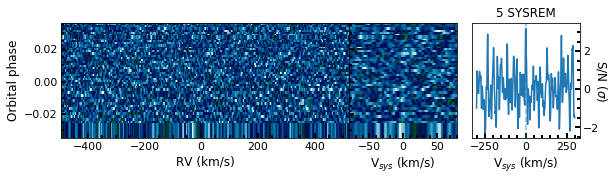

5 SYSREM
S/N = 4.401876144436595
Kp  = 199 km/s
Vsys= 208 km/s


<Figure size 432x288 with 0 Axes>

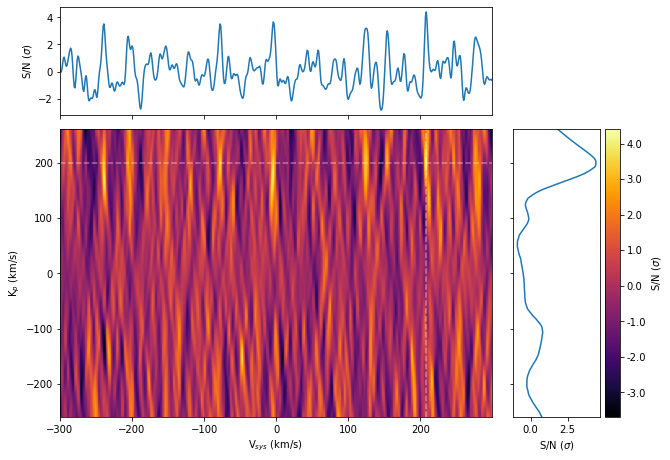

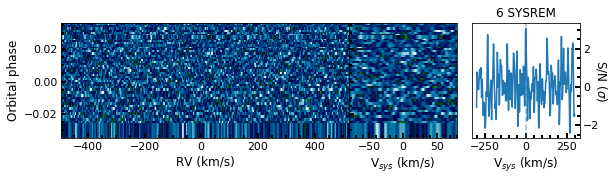

6 SYSREM
S/N = 4.384605398507776
Kp  = 199 km/s
Vsys= 208 km/s


<Figure size 432x288 with 0 Axes>

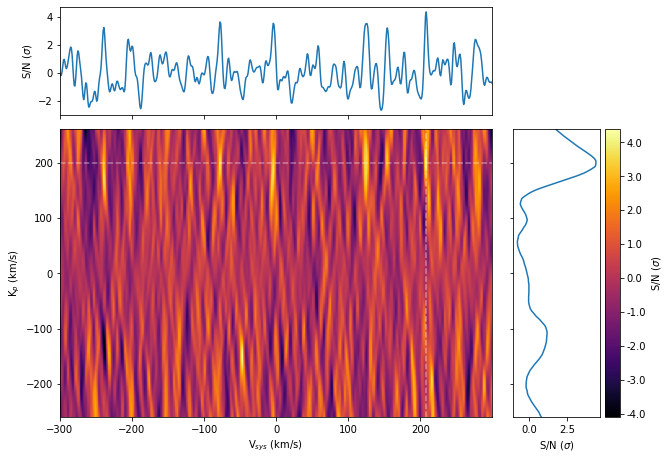

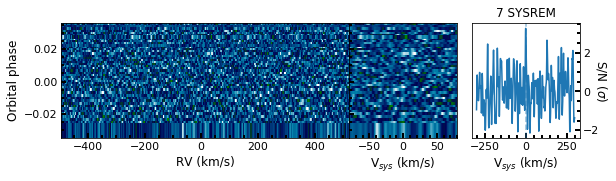

7 SYSREM
S/N = 4.917666259938986
Kp  = 199 km/s
Vsys= 208 km/s


<Figure size 432x288 with 0 Axes>

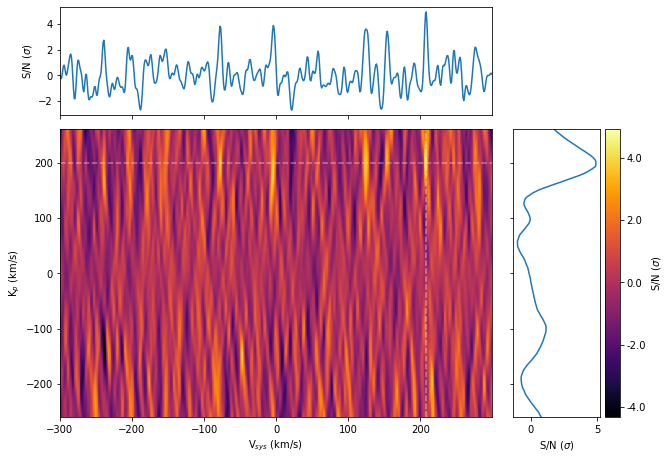

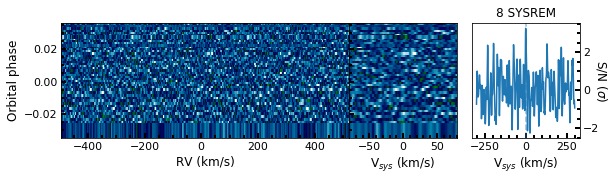

8 SYSREM
S/N = 5.428378555861887
Kp  = 200 km/s
Vsys= 208 km/s


<Figure size 432x288 with 0 Axes>

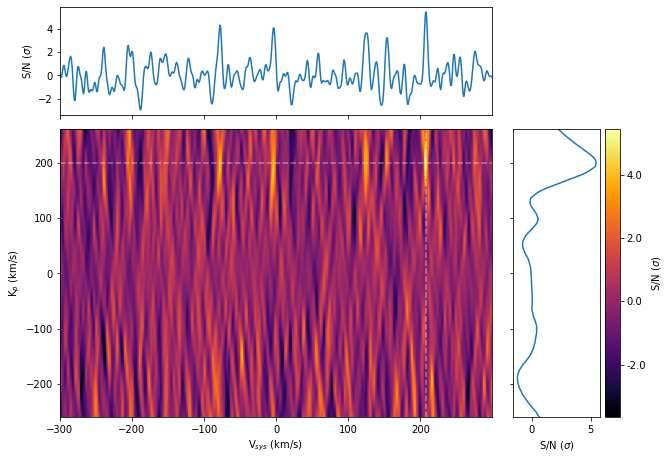

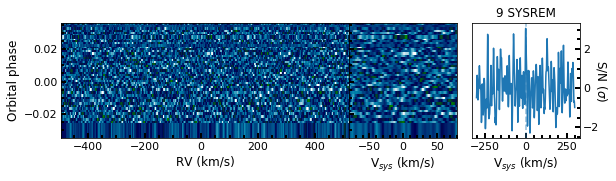

9 SYSREM
S/N = 4.780393706810446
Kp  = 202 km/s
Vsys= 208 km/s


<Figure size 432x288 with 0 Axes>

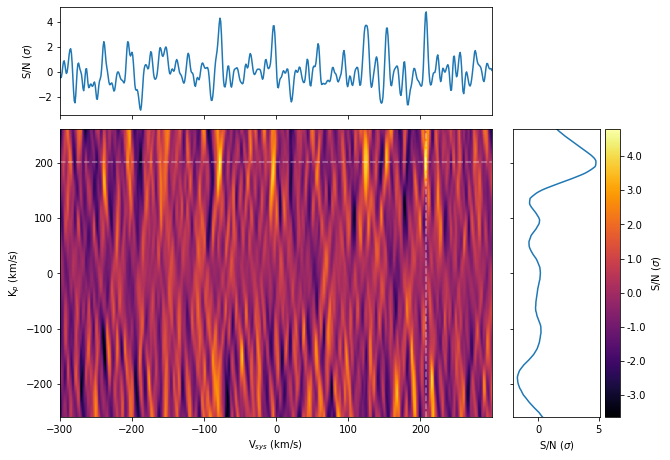

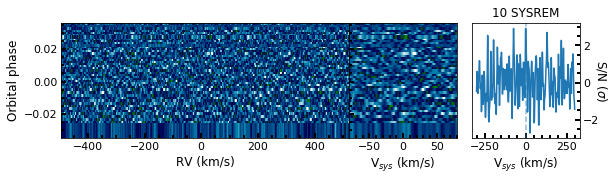

10 SYSREM
S/N = 5.207206113819203
Kp  = 201 km/s
Vsys= 208 km/s


<Figure size 432x288 with 0 Axes>

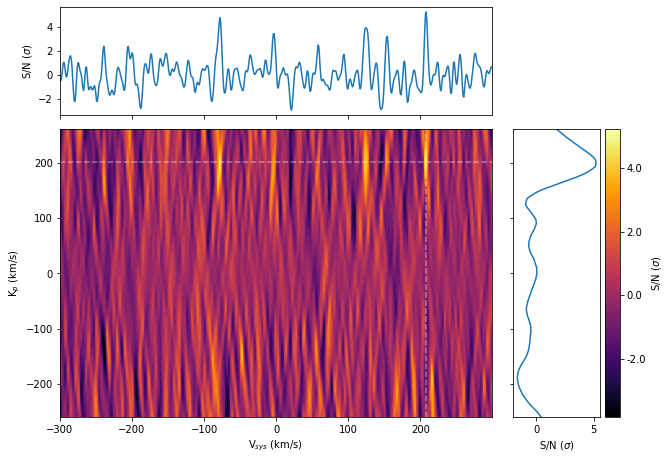

In [103]:
rect_im1 = [0.05, 0.8, 0.4,0.4]
rect_im2 = [0.05+0.4, 0.8, 0.15, 0.4]
rect_imcc= [0.05+0.4+0.15+0.02, 0.8, 0.15,0.4]

vsys_ex=-6 #expected Vsys
kp_ex=150 #expected Kp

vsys_sample=np.arange(-300,300,1)
kp_sample=np.arange(-260,261,1)

h5f_cc=h5py.File("./h2o1e-60-logL-flux.cc", 'r')

for sys in range (11): 
    cc_tot_mat=[]
    for order in range (len(ra)):
        rainbow_sys_col1=h5f_cc["CC-H2O-order-"+str(ra[order])][:][sys]
        cc_tot_mat.append(rainbow_sys_col1)
        
    cc_tot_norm=np.nansum(cc_tot_mat,axis=0) #sum up all order's cc 
    cc_tot_norm=cc_tot_norm-np.median(cc_tot_norm,axis=1)[:,np.newaxis]
    
    transweight=scaletrans
    
    rv_expected=kp_ex*np.sin(2.*np.pi*phase_p)+vsys_ex-rvcor
    #Aligning to the expected planet's RV
    cc_alg1=np.zeros((len(phase),len(vsys_sample)))
    for ph in range (len(phase)):
        v_ex=vsys_sample+rv_expected[ph]
        f_rv=sci.interp1d(drvs,cc_tot_norm[ph])
        cc_alg1[ph]=f_rv(v_ex)
    
    summedcc=np.sum(cc_alg1*transweight[:,np.newaxis],axis=0)
    
    sn_curve=summedcc/np.std(summedcc)
    
    
    plt.figure(figsize=(10,4))
    ax1=plt.axes(rect_im1,xlabel='RV (km/s)',ylabel=r'$\phi$')
    ax1.pcolormesh(drvs,phase_p,cc_tot_norm,cmap=cm.ocean,
                   vmin=np.mean(cc_tot_norm)-3*np.std(cc_tot_norm),
                   vmax=np.mean(cc_tot_norm)+3*np.std(cc_tot_norm))
    
    ax1.set_ylabel("Orbital phase",size=12)
    ax1.set_xlabel("RV (km/s)",size=12)
    ax1.minorticks_on()
    ax1.tick_params(which="both",direction='in',length=3, width=2,labelsize=11)
    ax1.tick_params(which="major",direction='in',length=5, width=2)
    
    ax2=plt.axes(rect_im2)
    im2=ax2.pcolormesh(vsys_sample,phase_p,cc_alg1,cmap=cm.ocean,
                       vmin=np.mean(cc_alg1)-3*np.std(cc_alg1),
                       vmax=np.mean(cc_alg1)+3*np.std(cc_alg1))
    ax2.set_ylabel("")
    ax2.set_xlabel("V$_{sys}$ (km/s)",size=12)
    ax2.minorticks_on()
    ax2.tick_params(which="both",direction='in',length=3, width=2,labelsize=11)
    ax2.tick_params(which="major",direction='in',length=5, width=2)
    ax2.set_yticklabels("")
    ax2.set_xlim(-80,80)
    ax3=plt.axes(rect_imcc)

    ax3.plot(vsys_sample,sn_curve,"-")
    ax3.axvline(x=0,ls="--",alpha=0.5)
    ax3.set_xlabel("V$_{sys}$ (km/s)",size=12)
    ax3.yaxis.set_ticks_position('right')
    ax3.set_ylabel("S/N ($\sigma$)",size=12,rotation=270,labelpad=10)
    ax3.yaxis.set_label_position("right")
    ax3.minorticks_on()
    ax3.tick_params(which="both",direction='in',length=3, width=2,labelsize=11)
    ax3.tick_params(which="major",direction='in',length=5, width=2)
    plt.title(str(sys)+" SYSREM")
    plt.show()
    plt.clf()
    summed=kpvsys_calc(kp_sample,vsys_sample,drvs,cc_tot_norm*transweight[:,np.newaxis],np.array(phase),-np.array(rvcor),mask)

    kp_fig(summed,vsys_sample,kp_sample)

h5f_cc.close()    

## Using Pearson CCF

$\mathrm{CCF}= \frac{\sum (f_{i}-\bar{f}) (m_{i}-\bar{m})}{\sqrt{\sum (f_{i}-\bar{f})^{2}} \sqrt{\sum (m_{i}-\bar{m})^{2}}}$

where $f_{i}$ is the data, $\bar{f}$ is the mean value of the data, $m_{i}$ is the doppler-shifted spectrum model, $m_{i}$ is the mean value of the doppler-shifted spectrum model, $i$ is the wavelength bin.

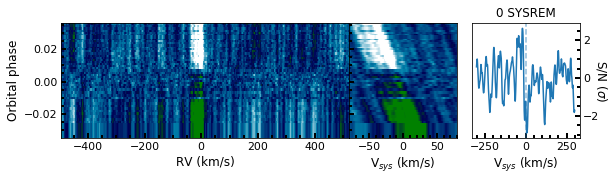

0 SYSREM
S/N = 6.326722172178492
Kp  = -156 km/s
Vsys= 0 km/s


<Figure size 432x288 with 0 Axes>

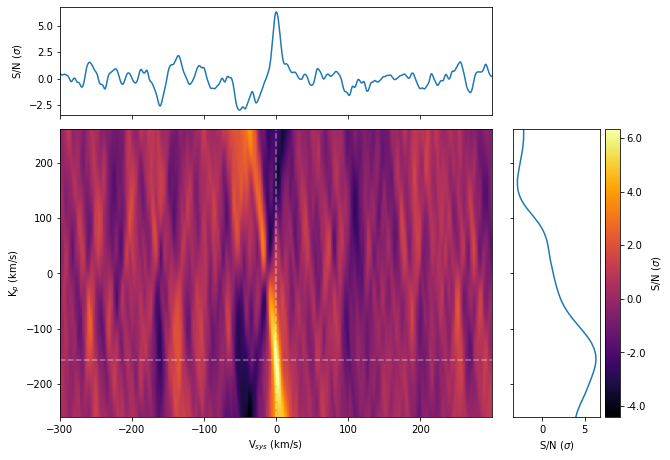

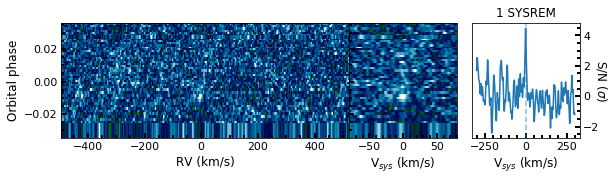

1 SYSREM
S/N = 5.32092927784379
Kp  = 139 km/s
Vsys= -7 km/s


<Figure size 432x288 with 0 Axes>

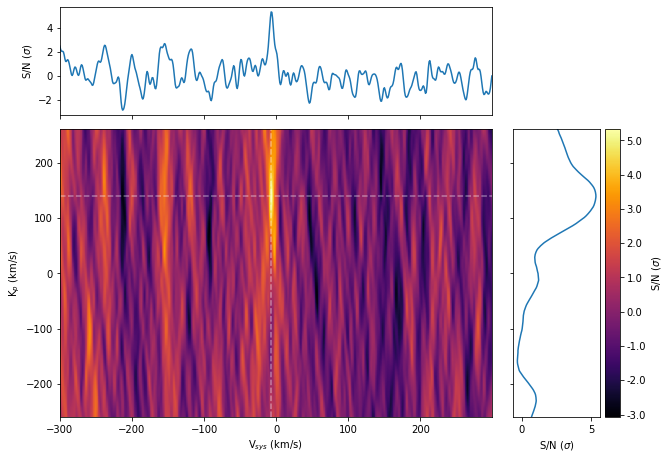

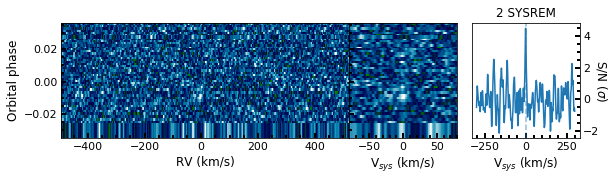

2 SYSREM
S/N = 5.407434097713053
Kp  = 145 km/s
Vsys= -7 km/s


<Figure size 432x288 with 0 Axes>

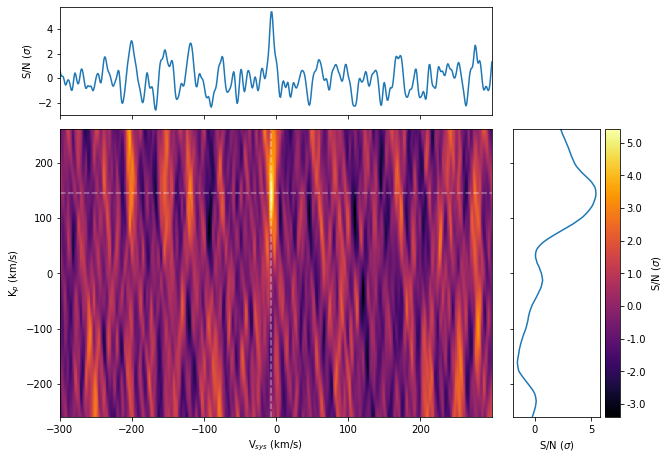

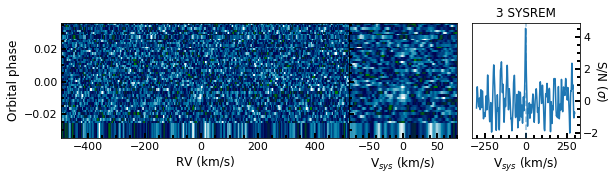

3 SYSREM
S/N = 5.338353979569672
Kp  = 146 km/s
Vsys= -6 km/s


<Figure size 432x288 with 0 Axes>

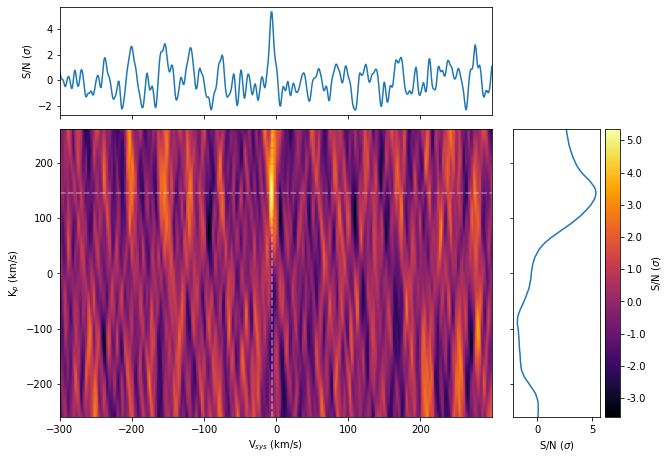

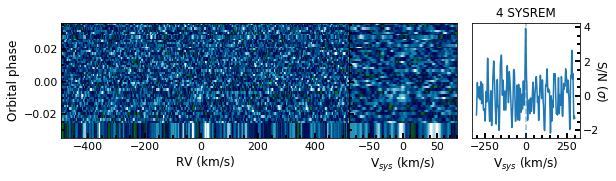

4 SYSREM
S/N = 4.609788040271225
Kp  = 147 km/s
Vsys= -7 km/s


<Figure size 432x288 with 0 Axes>

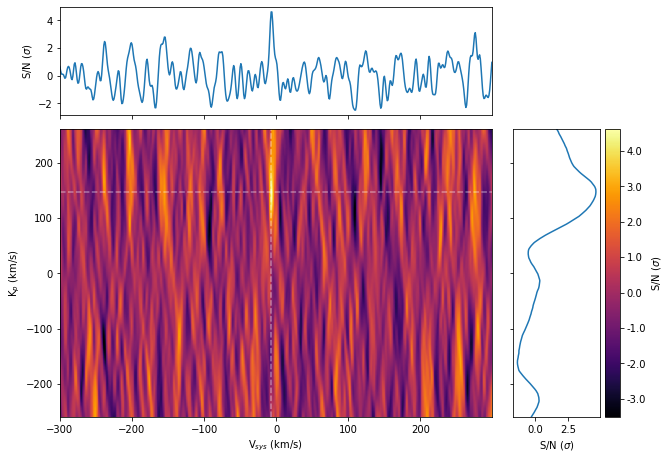

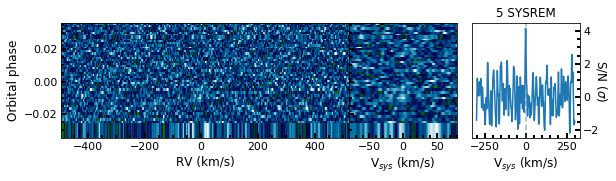

5 SYSREM
S/N = 4.693514945978008
Kp  = 142 km/s
Vsys= -7 km/s


<Figure size 432x288 with 0 Axes>

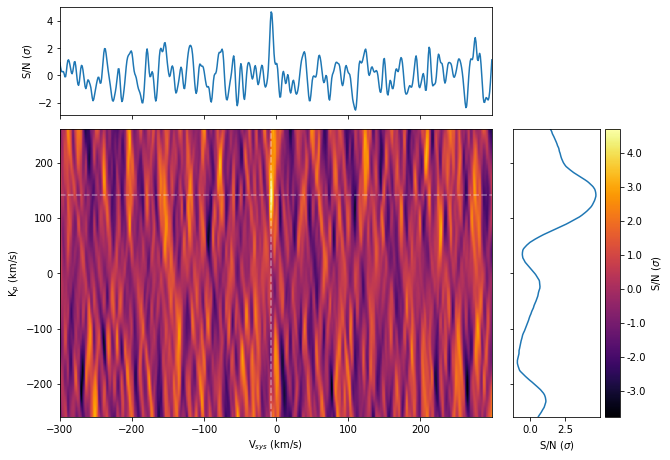

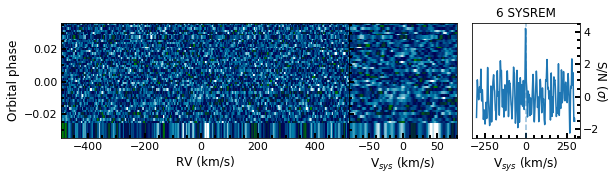

6 SYSREM
S/N = 4.669651679991091
Kp  = 142 km/s
Vsys= -7 km/s


<Figure size 432x288 with 0 Axes>

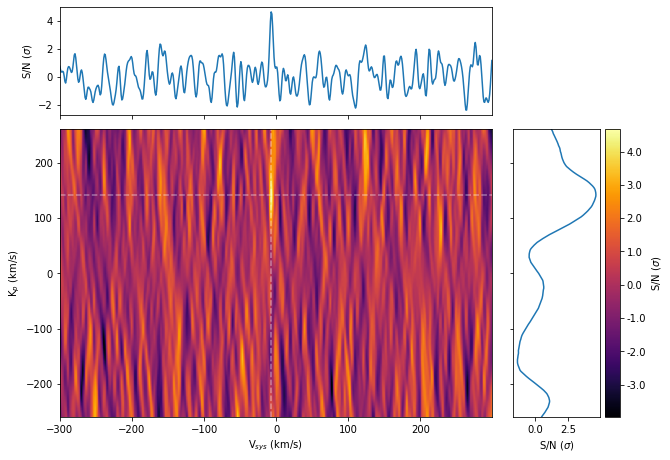

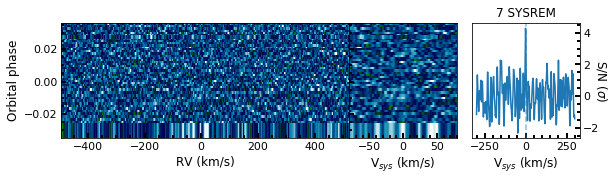

7 SYSREM
S/N = 4.71837741316779
Kp  = 142 km/s
Vsys= -7 km/s


<Figure size 432x288 with 0 Axes>

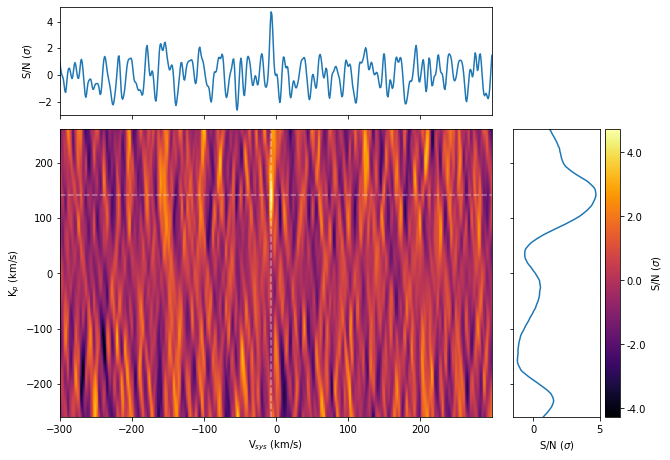

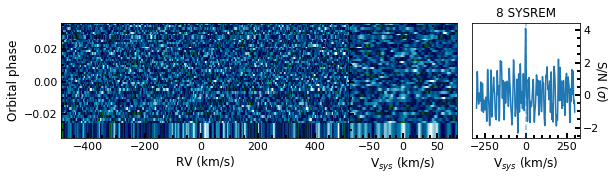

8 SYSREM
S/N = 4.6739095038019505
Kp  = 138 km/s
Vsys= -7 km/s


<Figure size 432x288 with 0 Axes>

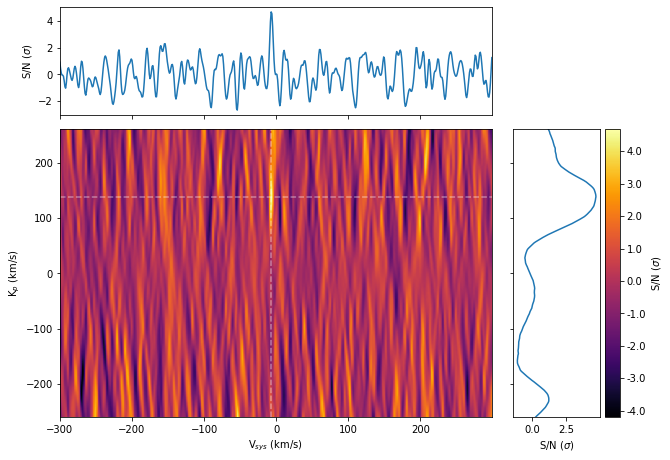

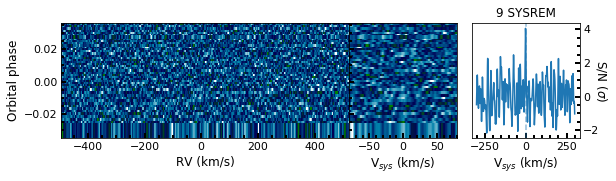

9 SYSREM
S/N = 4.55795928849012
Kp  = 140 km/s
Vsys= -7 km/s


<Figure size 432x288 with 0 Axes>

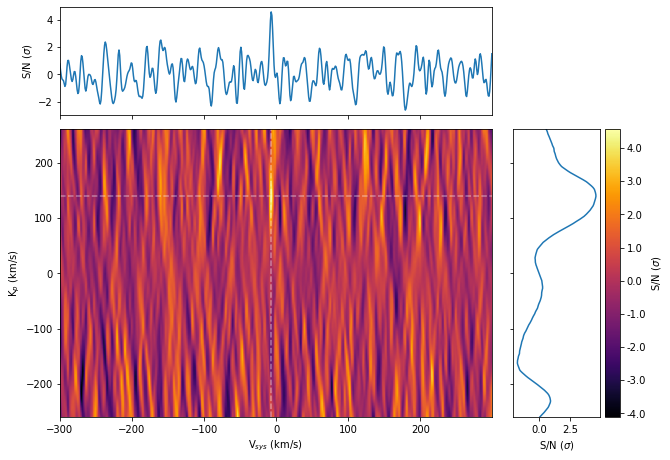

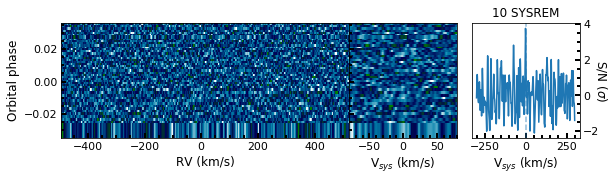

10 SYSREM
S/N = 4.392010124565562
Kp  = 138 km/s
Vsys= -7 km/s


<Figure size 432x288 with 0 Axes>

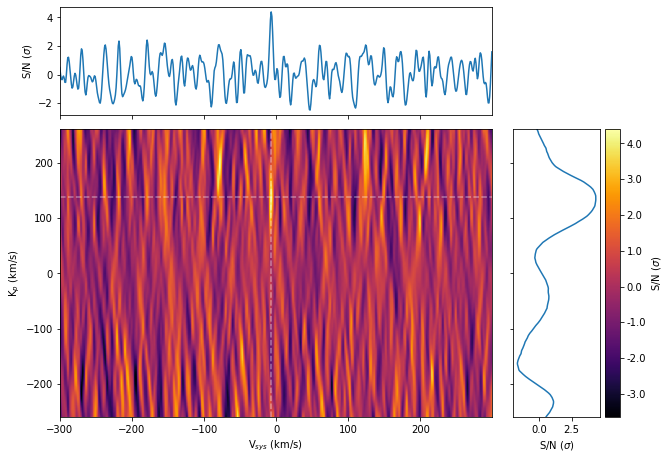

In [104]:
rect_im1 = [0.05, 0.8, 0.4,0.4]
rect_im2 = [0.05+0.4, 0.8, 0.15, 0.4]
rect_imcc= [0.05+0.4+0.15+0.02, 0.8, 0.15,0.4]

vsys_ex=-6 #expected Vsys
kp_ex=150 #expected Kp

vsys_sample=np.arange(-300,300,1)
kp_sample=np.arange(-260,261,1)

h5f_cc=h5py.File("./h2o1e-60-pearson-flux.cc", 'r')

for sys in range (11): 
    cc_tot_mat=[]
    for order in range (len(ra)):
        rainbow_sys_col1=h5f_cc["CC-H2O-order-"+str(ra[order])][:][sys]
        cc_tot_mat.append(rainbow_sys_col1)
        
    cc_tot_norm=np.nansum(cc_tot_mat,axis=0) #sum up all order's cc 
    cc_tot_norm=cc_tot_norm-np.median(cc_tot_norm,axis=1)[:,np.newaxis]
    
    transweight=scaletrans
    
    rv_expected=kp_ex*np.sin(2.*np.pi*phase_p)+vsys_ex-rvcor
    #Aligning to the expected planet's RV
    cc_alg1=np.zeros((len(phase),len(vsys_sample)))
    for ph in range (len(phase)):
        v_ex=vsys_sample+rv_expected[ph]
        f_rv=sci.interp1d(drvs,cc_tot_norm[ph])
        cc_alg1[ph]=f_rv(v_ex)
    
    summedcc=np.sum(cc_alg1*transweight[:,np.newaxis],axis=0)
    
    sn_curve=summedcc/np.std(summedcc)
    
    
    plt.figure(figsize=(10,4))
    ax1=plt.axes(rect_im1,xlabel='RV (km/s)',ylabel=r'$\phi$')
    ax1.pcolormesh(drvs,phase_p,cc_tot_norm,cmap=cm.ocean,
                   vmin=np.mean(cc_tot_norm)-3*np.std(cc_tot_norm),
                   vmax=np.mean(cc_tot_norm)+3*np.std(cc_tot_norm))
    
    ax1.set_ylabel("Orbital phase",size=12)
    ax1.set_xlabel("RV (km/s)",size=12)
    ax1.minorticks_on()
    ax1.tick_params(which="both",direction='in',length=3, width=2,labelsize=11)
    ax1.tick_params(which="major",direction='in',length=5, width=2)
    
    ax2=plt.axes(rect_im2)
    im2=ax2.pcolormesh(vsys_sample,phase_p,cc_alg1,cmap=cm.ocean,
                       vmin=np.mean(cc_alg1)-3*np.std(cc_alg1),
                       vmax=np.mean(cc_alg1)+3*np.std(cc_alg1))
    ax2.set_ylabel("")
    ax2.set_xlabel("V$_{sys}$ (km/s)",size=12)
    ax2.minorticks_on()
    ax2.tick_params(which="both",direction='in',length=3, width=2,labelsize=11)
    ax2.tick_params(which="major",direction='in',length=5, width=2)
    ax2.set_yticklabels("")
    ax2.set_xlim(-80,80)
    ax3=plt.axes(rect_imcc)

    ax3.plot(vsys_sample,sn_curve,"-")
    ax3.axvline(x=0,ls="--",alpha=0.5)
    ax3.set_xlabel("V$_{sys}$ (km/s)",size=12)
    ax3.yaxis.set_ticks_position('right')
    ax3.set_ylabel("S/N ($\sigma$)",size=12,rotation=270,labelpad=10)
    ax3.yaxis.set_label_position("right")
    ax3.minorticks_on()
    ax3.tick_params(which="both",direction='in',length=3, width=2,labelsize=11)
    ax3.tick_params(which="major",direction='in',length=5, width=2)
    plt.title(str(sys)+" SYSREM")
    plt.show()
    plt.clf()
    summed=kpvsys_calc(kp_sample,vsys_sample,drvs,cc_tot_norm*transweight[:,np.newaxis],np.array(phase),-np.array(rvcor),mask)

    kp_fig(summed,vsys_sample,kp_sample)

h5f_cc.close()    

# Phase Shuffling

In [38]:
shuff_cch2o=[]
sys=5 #number of SYSREM iteration
vsys_ex=-6 #expected Vsys
kp_ex=150 #expected Kp

cc_mat=np.copy(ccallh2o[sys])

cc_alg1=np.zeros((len(phase),vsystotal))
for ph in range (len(phase)):
    rv_expected=kp_ex*np.sin(2.*np.pi*phase_p[ph])+vsys_ex-rvcor[ph]
    v_ex=np.linspace(rv_expected+vsys_min,rv_expected+vsys_max+step,vsystotal)
    f_rv=sci.interp1d(drvs,ccallh2o[sys][ph])
    cc_alg1[ph]=f_rv(v_ex)

transitweight=np.outer(scaletrans,np.ones(len(cc_alg1[0])))

intransitcc=cc_alg1*transitweight

shuff_cch2o.append(np.sum(intransitcc,axis=0)/np.sum(scaletrans))


for i in tnrange(10000):
    np.random.shuffle(cc_mat)
    cc_alg1=np.zeros((len(phase),vsystotal))
    for ph in range (len(phase)):
        rv_expected=kp_ex*np.sin(2.*np.pi*phase_p[ph])+vsys_ex-rvcor[ph]
        v_ex=np.linspace(rv_expected+vsys_min,rv_expected+vsys_max+step,vsystotal)
        f_rv=sci.interp1d(drvs,cc_mat[ph])
        cc_alg1[ph]=f_rv(v_ex)
    intransitcc=cc_alg1*transitweight
    shuff_cch2o.append(np.sum(intransitcc,axis=0)/np.sum(scaletrans))

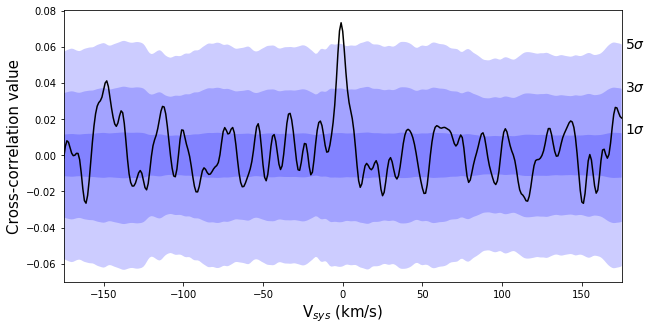

<Figure size 432x288 with 0 Axes>

In [42]:
vsys_rv=np.arange(vsysmin,vsysmax+step,step)
stdcc=np.std(shuff_cch2o[1:],axis=0)
stdmed=np.median(stdcc)

plt.figure(figsize=(10,5))
plt.fill_between(vsys_rv, -stdcc, stdcc, facecolor='blue', interpolate=True,alpha=0.2)
plt.fill_between(vsys_rv, -3*stdcc, 3*stdcc, facecolor='blue', interpolate=True,alpha=0.2)
plt.fill_between(vsys_rv, -5*stdcc, 5*stdcc, facecolor='blue', interpolate=True,alpha=0.2)
plt.plot(vsys_rv,shuff_cch2o[0],"k")
plt.ylabel("Cross-correlation value",size=15)
plt.xlabel("V$_{sys}$ (km/s)",size=15)
plt.text(177,5*np.mean(stdcc),"5$\sigma$",size=14)
plt.text(177,3*np.mean(stdcc),"3$\sigma$",size=14)
plt.text(177,1*np.mean(stdcc),"1$\sigma$",size=14)
#plt.ylim(-12,12)
plt.xlim(-175,175)
plt.show()
plt.clf()  